In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
covertype = fetch_ucirepo(id=31) 
  
# data (as pandas dataframes) 
X = covertype.data.features 
y = covertype.data.targets 

In [4]:
# metadata 
print(covertype.metadata) 
  
# variable information 
print(covertype.variables) 

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [5]:
def simple_heuristic(X):
    X_step = X + 1
    y = pd.DataFrame(X_step.product(axis='columns')%7 + 1)
    return y

In [6]:
import numpy as np
sh_y = np.array(simple_heuristic(X))
score_model_0 = (sh_y == y.values).sum() / len(y)
print(f"Model_0 score: {score_model_0}")
sh_y

Model_0 score: 0.14624827025947829


array([[6],
       [5],
       [4],
       ...,
       [5],
       [5],
       [6]])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(464809, 116203)

In [8]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
model_1 = AdaBoostClassifier(algorithm="SAMME", random_state=42)
model_2 = RandomForestClassifier(max_depth=15, max_features=10, random_state=42)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

score_model_1 = model_1.score(X_test, y_test)
score_model_2 = model_2.score(X_test, y_test)

print(f"Model_1 score: {score_model_1}")
print(f"Model_2 score: {score_model_2}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model_1 score: 0.6518850632083509
Model_2 score: 0.8415703553264545


In [60]:
import torch
from torch import nn

class NeuralNetworkModel(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=54, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.Dropout(p=0.2),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=7)
        )
        
    def forward(self, x):
        return self.layers(x)

In [10]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long).squeeze()
y_test = torch.tensor(y_test.values, dtype=torch.long).squeeze()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([464809, 54]),
 torch.Size([116203, 54]),
 torch.Size([464809]),
 torch.Size([116203]))

In [11]:
y_train -= 1
y_test -= 1

In [17]:
loss_fn = nn.CrossEntropyLoss()

def train(model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               epochs:int):
    
    test_acc = 0
    test_loss = 0
    for epoch in range(epochs):
        model.train()
        y_logits = model(X_train)
        y_preds = torch.softmax(y_logits, dim=1).argmax()
        
        loss = loss_fn(y_logits, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if epoch % 50 == 0:
        #     curr_loss, curr_acc = test(model, loss_fn)
        #     if curr_acc <= test_acc and curr_loss >= test_loss: # checking if model is overfitting
        #         print(f"Model started to overfit, ending teatching at epoch: {epoch}")
        #         return epoch
        #     test_loss, test_acc = curr_loss, curr_acc
    return epochs

def test(model:torch.nn.Module,
               loss_fn:torch.nn.Module):
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_test)
        test_loss = loss_fn(y_logits, y_test)
        y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        test_acc = (y_preds == y_test).sum().item() / len(y_test)
        
    return test_loss, test_acc

In [13]:
def set_best_hyperparameters(hidden_units, lr, epochs):
    return {"hidden_units":hidden_units, "lr":lr, "epochs":epochs}

In [14]:
torch.manual_seed(42)

best_hyperparameters = set_best_hyperparameters(0, 0, 0)
best_test_acc = 0

for hidden_units in range(8, 13):
    lr = 0.001
    while lr <= 0.1:
        for epochs in range(100, 1001, 100):
            model_5 = NeuralNetworkModel(hidden_units=hidden_units)
            optimizer = torch.optim.Adam(params=model_5.parameters(), lr=lr, weight_decay=1e-5)
            num_ep = train(model=model_5, loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)
            test_loss, test_acc = test(model=model_5, loss_fn=loss_fn)

            print(f"Number of epochs: {num_ep} | Hidden_units: {hidden_units} | Learing rate: {lr}")
            print(f"Test loss: {test_loss}  |  Test accuracy: {test_acc}")
            print("--------------------------------------------------------------------------------\n")

            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_hyperparameters = set_best_hyperparameters(hidden_units, lr, num_ep)

            if num_ep < epochs: # this means, that model started to overfit
                break

        lr *= 10

print(f"Best test acc: {best_test_acc} with hyperparameters: {best_hyperparameters}")

In [57]:
torch.manual_seed(42)
model_5 = NeuralNetworkModel(hidden_units=12)
optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.01)
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []
epoch_count = []
for epoch in range(1001):
    model_5.train()
    y_logits = model_5(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train)
    train_acc = (y_preds == y_train).sum().item() / len(y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        model_5.eval()
        with torch.inference_mode():
            test_logits = model_5(X_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = (test_preds == y_test).sum().item() / len(y_test)
            
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        train_acc_values.append(train_acc)
        test_acc_values.append(test_acc)
        print(f"Epoch {epoch} done")

Epoch 0 done
Epoch 50 done
Epoch 100 done
Epoch 150 done
Epoch 200 done
Epoch 250 done
Epoch 300 done
Epoch 350 done
Epoch 400 done
Epoch 450 done
Epoch 500 done
Epoch 550 done
Epoch 600 done
Epoch 650 done
Epoch 700 done
Epoch 750 done
Epoch 800 done
Epoch 850 done
Epoch 900 done
Epoch 950 done
Epoch 1000 done


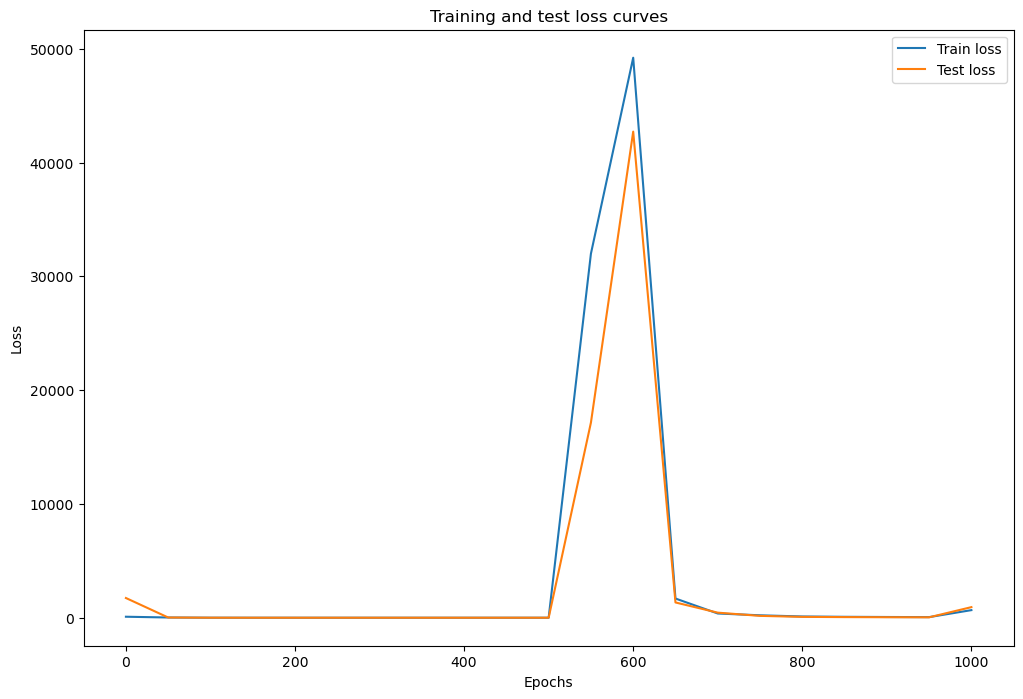

In [58]:
plt.figure(figsize=(12, 8))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

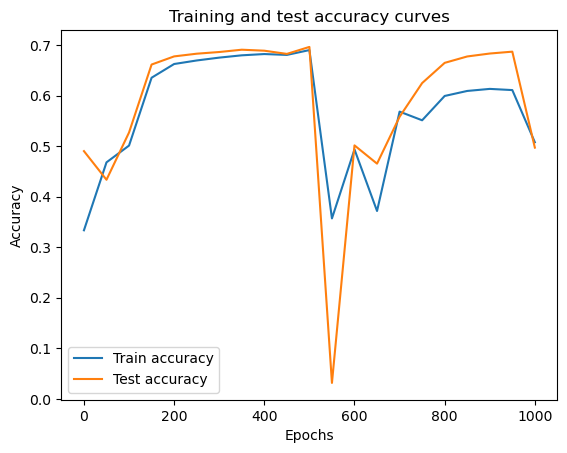

In [59]:
plt.plot(epoch_count, train_acc_values, label="Train accuracy")
plt.plot(epoch_count, test_acc_values, label="Test accuracy")
plt.title("Training and test accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()